## 1 Testing model

In [1]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('wdbc.data')
df.head()

,842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,...,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [3]:
df.shape

(568, 32)

In [4]:
df.iloc[:, 1].values[:5]

array(['M', 'M', 'M', 'M', 'M'], dtype=object)

In [5]:
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [6]:
le.transform(['M', 'B'])

array([1, 0])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

Объединение StandartScaler, PCA, LogisticRegression в Pipeline:

<img src="pic/pipeline.png" width="400" height="500"/>

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1,
                                           solver='lbfgs'))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('acc: ', pipe_lr.score(X_test, y_test))

acc:  0.9298245614035088


#### k-cross validation

<img src="pic/kcv.png" width="400" height="500"/>

In [9]:
# итератор StratifiedKfold - сохраняет доли классов в обучающем наборе
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f"Блок {k+1}, Распределение классов:{np.bincount(y_train[train])}, {score}")

Блок 1, Распределение классов:[256 152], 0.9130434782608695
Блок 2, Распределение классов:[256 152], 0.9347826086956522
Блок 3, Распределение классов:[256 152], 0.9565217391304348
Блок 4, Распределение классов:[256 152], 0.8913043478260869
Блок 5, Распределение классов:[257 152], 0.9777777777777777
Блок 6, Распределение классов:[257 152], 0.9777777777777777
Блок 7, Распределение классов:[257 152], 0.9777777777777777
Блок 8, Распределение классов:[257 152], 0.9111111111111111
Блок 9, Распределение классов:[257 152], 0.9333333333333333
Блок 10, Распределение классов:[256 153], 0.9777777777777777


In [10]:
print('acc: ', np.mean(scores), '+-', np.std(scores))

acc:  0.9451207729468599 +- 0.03118259258959474


In [11]:
# cros val srore - стратифицированная перекрестная проверка по к блокам
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)

print('Меры точности перекрестной проверки: ', scores)
print('Точность перекрестной проверки: ', np.mean(scores), '+-',
      np.std(scores))

Меры точности перекрестной проверки:  [0.91304348 0.93478261 0.95652174 0.89130435 0.97777778 0.97777778
 0.97777778 0.91111111 0.93333333 0.97777778]
Точность перекрестной проверки:  0.9451207729468599 +- 0.03118259258959474


#### Отладка алгоритмов с помощью кривых обучения и проверки 

Модель с высоким смещением (недообучение) - увеличение количества параметров модели, конструирование или сбор новых признаков, уменьшение степени регуляризации.

Модель с высокой дисперсией (переобучение) - сбор большего числа обучающих данных, снижение сложности модели, увеличение параметра регуляризации.

В случае нерегуляризованных моделей снижению степени переобучения может способствовать уменьшение количества признаков путем выбора или выделения признаков.

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(random_state=1,
                                           max_iter=10000))

train_sizes, train_scores, test_scores =\
    learning_curve(estimator=pipe_lr, X=X_train,
                   y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
                   cv=10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

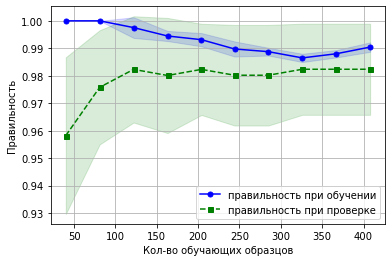

In [13]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--', marker='s',
         markersize=5, label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Кол-во обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='lower right')
plt.show()

Кривая обучения варьирует размер выборки.

Кривая проверки варьирует параметры модели (регуляризация для логистической регрессии)

In [14]:
pipe_lr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'logisticregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [15]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores =\
    validation_curve(estimator=pipe_lr,
                     X=X_train,
                     y=y_train,
                     param_name='logisticregression__C',
                     param_range=param_range,
                     cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

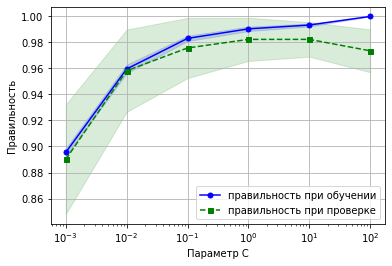

In [16]:
plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='правильность при обучении')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--', marker='s',
         markersize=5, label='правильность при проверке')
plt.fill_between(param_range, test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Параметр C')
plt.ylabel('Правильность')
plt.legend(loc='lower right')
plt.show()

Небольшие значения параметра C (увеличение степени регуляризации) свидетельствуют о недостаточном обучении модели.

Большие значения параметра C (снижение степени регуляризации) переобучивает модель.

Оптимальные значения между 0.01 и 0.1

#### Grid search (решетачный поиск)

Поиск оптимальной комбинации значений гиперпараметров.

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10, refit=True, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9779710144927536
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [18]:
# оценка эффективности выбранной лучшей модели
clf = gs.best_estimator_
clf.fit(X_train, y_train)  # необязательно, refit=True обучает лучшую модель
clf.score(X_test, y_test)

0.9649122807017544

RandomizedSearchCV обычно работает почти так же хорошо, как и грубый поиск. В частности, если мы отбираем только 60 комбинаций параметров, то уже имеем 95% вероятность получения решений в пределах 5% оптимальной эффективности.

#### Вложенная перекрестная проверка

При вложенной перекрестной проверке истинная ошибка оценки оказывается почти не смещенной относительно испытательного набора.

При вложенной перекрестной проверке мы организуем внешний цикл перекрестной проверки по k блокам для разбиения данных на обучающие и испытательные блоки, а также применяем внутренний цикл для отбора модели с использованием перекрестной проверки по k блокам на обучающем блоке.

<img src="pic/incv.png" width="400" height="500"/>

In [19]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(f'Точность перекрестной проверки: {np.mean(scores)} +- {np.std(scores)}')

Точность перекрестной проверки: 0.9780219780219781 +- 0.012037858406706946


In [20]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(
                            random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3,
                                             4, 5, 6,
                                             7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy',
                         cv=5)
print(f'Точность перекрестной проверки: {np.mean(scores)} +- {np.std(scores)}')

Точность перекрестной проверки: 0.9317704517704518 +- 0.017448684188627404


## Scores

Матрица неточностей - квадратная матрица, описывающая численности истинно положительных (true positive - TP), истинно отрицательных (true negative - TN), ложноположительных (false positive - FP), ложноотрицательных (false negative - FN) прогнозов классификатора.

<img src="pic/matrixf.png" width="250"/>

In [21]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[72  0]
 [ 5 37]]


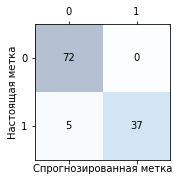

In [22]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                va='center', ha='center')
plt.xlabel('Спрогнозированная метка')
plt.ylabel('Настоящая метка')
plt.show()

Ошибка и правильность прогноза представляют информацию о том, сколько образцов классифицираванно неправильно.

Ошибка - сумма всех ложных прогнозов, деленная на общее кол-во прогнозов:
$$ERR=\frac{FP+FN}{FP+FN+TP+TN} $$
Правильность:
$$ACC=\frac{TP+TN}{FP+FN+TP+TN}=1-ERR $$

Accuracy — это показатель, который описывает общую точность предсказания модели по всем классам. Это особенно полезно, когда каждый класс одинаково важен. Стоит учесть, что метрика accuracy может быть обманчивой. Один из таких случаев — это несбалансированные данные.

Доля истинно положительных (true positive rate - TPR) и доля ложноположительных классификаций (false positive rate - FPR) являются метриками эффиктивности, которые особенно полезны в задачах с дисбалансом классов:
$$FPR=\frac{FP}{N}=\frac{FP}{FP+TN} $$
$$TPR=\frac{TP}{P}=\frac{TP}{TP+FN} $$

Метрики эффективности точность (PRE) и полнота (REC) связаны с долями истино положиетльных и отрицательных классификаций. 

$$PRE=\frac{TP}{TP+FP}$$
$$REC=\frac{TP}{P}=\frac{TP}{FN+TP} $$

Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов.

Precision это какой процент из тех пациентов, которых модель определила, как больных пневмонией, действительно больны пневмонией (и соответственно, какой обратный к этому процент врачи, таким образом, будут по ошибке лечить не от той болезни). Recall — это какой процент всех пациентов, больных пневмонией обнаружит модель (обратный к этому процент — сколько пациентов, больных пневмонией модель разметит как здоровых).

(PRE=0.33) - алгоритм делает 66% ложных срабатываний

(REC=0.1) - выявляет только 10% первого класса

В том случае, если Precision и Recall являются одинаково значимыми, можно использовать их среднее гармоническое для получения оценки результатов:
$$F1=2\frac{PRE*REC}{PRE+REC}$$

In [23]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('pre: ', precision_score(y_true=y_test, y_pred=y_pred))
print('rec: ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1: ', f1_score(y_true=y_test, y_pred=y_pred))

pre:  1.0
rec:  0.8809523809523809
f1:  0.9367088607594937


Представьте, что вам дали изображение и попросили определить все автомобили внутри него. Какой показатель вы используете? Поскольку цель состоит в том, чтобы обнаружить все автомобили, используйте recall. Такой подход может ошибочно классифицировать некоторые объекты как целевые, но в конечном итоге сработает для предсказания всех автомобилей.

Теперь предположим, что вам дали снимок с результатами маммографии, и вас попросили определить наличие рака. Какой показатель вы используете? Поскольку он обязан быть чувствителен к неверной идентификации изображения как злокачественного, мы должны быть уверены, когда классифицируем снимок как Positive (то есть с раком). Таким образом, предпочтительным показателем в данном случае является precision.

In [24]:
pipe_svc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [25]:
from sklearn.metrics import make_scorer, f1_score

c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9828077166509601
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


ROC (receiver operating characteristic) – график, показывающий зависимость верно классифицируемых объектов положительного класса от ложно положительно классифицируемых объектов негативного класса. Иными словами, соотношение True Positive Rate (Recall) и False Positive Rate.

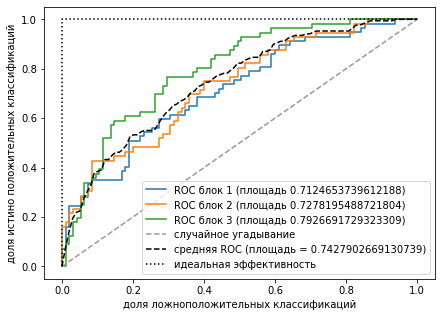

In [26]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1,
                                           C=100.0))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train,
                                            y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC блок {i+1} (площадь {roc_auc})')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='случайное угадывание')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'средняя ROC (площадь = {mean_auc})')
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='идеальная эффективность')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных классификаций')
plt.ylabel('доля истино положительных классификаций')
plt.legend(loc='lower right')
plt.show()

#### Решение проблемы с дисбалансом классов

In [27]:
# создание несбалансированногоо набора данных 357 доброкачественных
# и 40 злокачественных
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [41]:
X_imb[y_imb == 0].shape[0] / (X_imb[y_imb == 0].shape[0] +\
                              X_imb[y_imb == 1].shape[0])

0.8992443324937027

Повышение (или понижение) дискретизации миноритарного (или мажоритарного) класса за счет выборки с возвращением новых образцов из набора данных.

In [30]:
from sklearn.utils import resample

print('Начальное кол-во образцов класса 1: ',
      X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(
    X_imb[y_imb == 1],
    y_imb[y_imb == 1],
    replace=True,
    n_samples=X_imb[y_imb == 0].shape[0],
    random_state=123)
print('Конечное кол-во образцов класса 1: ',
      X_upsampled.shape[0])

Начальное кол-во образцов класса 1:  40
Конечное кол-во образцов класса 1:  357


In [37]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [40]:
X_bal[y_bal == 0].shape[0] / (X_bal[y_bal == 0].shape[0] +\
                              X_bal[y_bal == 1].shape[0])

0.5

In [ ]:
# генерация новых обучающих данных метод SMOTE из imbalanced-learn